# pix2pix for Maps to Aerial Image Translation

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import pixutils as pxu
from pix2pix import UNet, PatchGAN, fit
import wandb
import os

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
train_path = "pix2pix-maps/train/*.jpg"
val_path = "pix2pix-maps/val/*.jpg"

buffer_size = 256
patch_size = 256

config = {
    "batch_size": 1,
    "lr_gen": 0.0002,
    "beta_1_gen": 0.5,
    "lr_disc": 0.0002,
    "beta_1_disc": 0.5,
    "l1_lambda": 100,
}

## Run the following code block on Kaggle only

In [4]:
train_path = f"/kaggle/input/{train_path}"
val_path = f"/kaggle/input/{val_path}"

## Load dataset

In [5]:
train = tf.data.Dataset.list_files(train_path)
val = tf.data.Dataset.list_files(val_path)

In [6]:
train = train.map(pxu.load_image)
train = train.map(lambda input_image, real_image: pxu.extract_patches(input_image, real_image, patch_size))
# data are in batches of size 'num_of_patches' after 'extract_patches'
train = train.unbatch()
train = train.map(lambda input_patches, real_patches: pxu.random_jitter(input_patches, real_patches, 286))
train = train.map(pxu.rescale_images)
train = train.shuffle(buffer_size)
train = train.batch(config["batch_size"])

val = val.map(pxu.load_image)
val = val.map(lambda input_image, real_image: pxu.extract_patches(input_image, real_image, patch_size))
# data are in batches of size 'num_of_patches' after 'extract_patches'
val = val.unbatch()
val = val.map(pxu.rescale_images)
val = val.batch(config["batch_size"])

## Visualize a few images

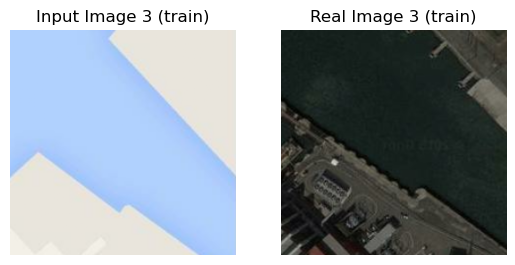

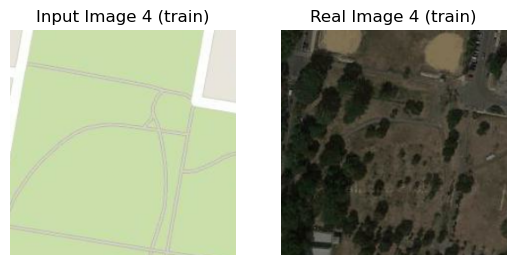

In [7]:
i = 0
for input_batch, real_batch in train.take(4):
    for input_image, real_image in zip(input_batch, real_batch):
        i += 1
        pxu.show(
            input_image,
            real_image,
            i,
            "train"
        )

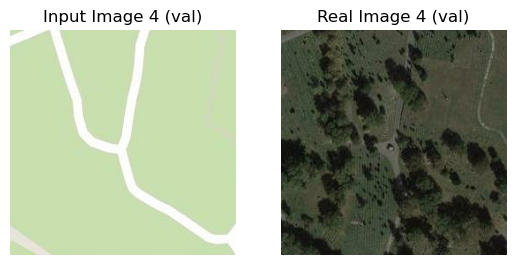

In [8]:
i = 0
for input_batch, real_batch in val.take(4):
    for input_image, real_image in zip(input_batch, real_batch):
        i += 1
        pxu.show(
            input_image,
            real_image,
            i,
            "val"
        )

## Create models

In [9]:
G = UNet(input_shape=(patch_size, patch_size, 3))
D = PatchGAN(input_shape=(patch_size, patch_size, 3))

config["epochs"] = 200

restore_last_epoch = 140
restore_run_id = "o7d6ymbr"

if restore_last_epoch is not None:
    config["epochs"] -= restore_last_epoch
    run_path = f"nsiete23/pix2pix/{restore_run_id}"
    gen_file = wandb.restore(f"checkpoints/generator_{restore_last_epoch}.h5", run_path=run_path)
    disc_file = wandb.restore(f"checkpoints/discriminator_{restore_last_epoch}.h5", run_path=run_path)
    G = load_model(gen_file.name)
    D = load_model(disc_file.name)
    print(
        "Resumed:",
        gen_file.name,
        disc_file.name,
        sep=os.linesep
    )

g_optim = Adam(learning_rate=config["lr_gen"], beta_1=config["beta_1_gen"])
d_optim = Adam(learning_rate=config["lr_disc"], beta_1=config["beta_1_disc"])

Resumed:
/kaggle/working/checkpoints/generator_140.h5
/kaggle/working/checkpoints/discriminator_140.h5


## Train

wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


2023-05-04 21:55:36.897654: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch: 1, Step: 4384, Gen Loss: 19.6443, Disc Loss: 0.2589


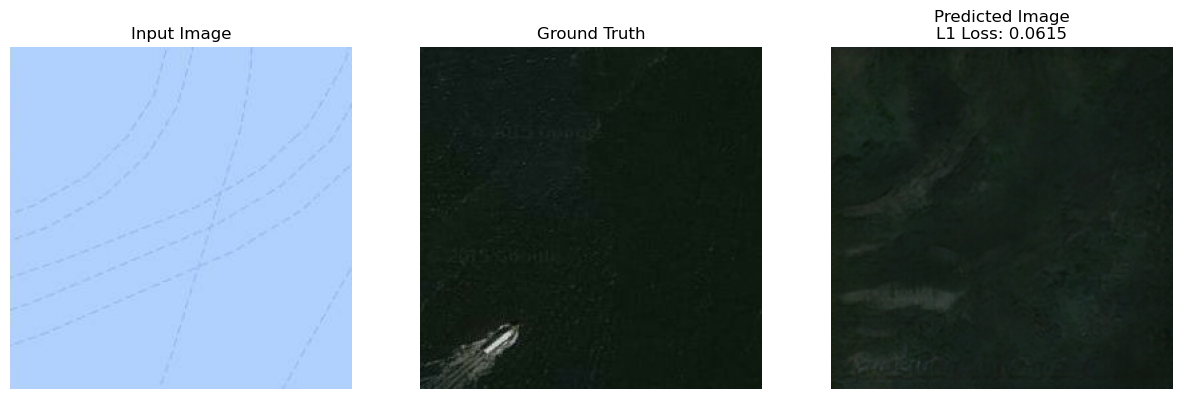

Epoch: 2, Step: 4384, Gen Loss: 18.9691, Disc Loss: 0.0864
Epoch: 3, Step: 4384, Gen Loss: 31.5060, Disc Loss: 0.5239
Epoch: 4, Step: 4384, Gen Loss: 22.9774, Disc Loss: 0.4769
Epoch: 5, Step: 4384, Gen Loss: 21.5834, Disc Loss: 0.1623
Epoch: 6, Step: 4384, Gen Loss: 34.6506, Disc Loss: 0.3453
Epoch: 7, Step: 4384, Gen Loss: 9.7668, Disc Loss: 0.44334
Epoch: 8, Step: 4384, Gen Loss: 28.9476, Disc Loss: 0.2217
Epoch: 9, Step: 4384, Gen Loss: 20.5164, Disc Loss: 0.9910
Epoch: 10, Step: 4384, Gen Loss: 6.4234, Disc Loss: 1.14922


Epoch: 11, Step: 4384, Gen Loss: 19.6891, Disc Loss: 0.5212
Epoch: 12, Step: 4384, Gen Loss: 23.7559, Disc Loss: 0.2010
Epoch: 13, Step: 4384, Gen Loss: 12.6493, Disc Loss: 0.6705
Epoch: 14, Step: 4384, Gen Loss: 30.6785, Disc Loss: 0.4659
Epoch: 15, Step: 4384, Gen Loss: 9.7708, Disc Loss: 0.18726
Epoch: 16, Step: 4384, Gen Loss: 25.7569, Disc Loss: 0.8761
Epoch: 17, Step: 4384, Gen Loss: 24.6574, Disc Loss: 1.0790
Epoch: 18, Step: 4384, Gen Loss: 35.1013, Disc Loss: 0.4165
Epoch: 19, Step: 4384, Gen Loss: 20.3124, Disc Loss: 0.8177
Epoch: 20, Step: 4384, Gen Loss: 27.8801, Disc Loss: 0.1728


Epoch: 21, Step: 4384, Gen Loss: 31.7952, Disc Loss: 2.8218
Epoch: 22, Step: 4384, Gen Loss: 13.3174, Disc Loss: 1.8361
Epoch: 23, Step: 4384, Gen Loss: 23.0752, Disc Loss: 0.4410
Epoch: 24, Step: 4384, Gen Loss: 24.7092, Disc Loss: 0.1580
Epoch: 25, Step: 4384, Gen Loss: 24.8994, Disc Loss: 0.2798
Epoch: 26, Step: 4384, Gen Loss: 30.7729, Disc Loss: 0.6409
Epoch: 27, Step: 4384, Gen Loss: 27.7365, Disc Loss: 0.7773
Epoch: 28, Step: 4384, Gen Loss: 18.6593, Disc Loss: 0.9315
Epoch: 29, Step: 4384, Gen Loss: 29.6983, Disc Loss: 0.3695
Epoch: 30, Step: 4384, Gen Loss: 25.3942, Disc Loss: 0.3366


Epoch: 31, Step: 4384, Gen Loss: 34.5500, Disc Loss: 0.2320
Epoch: 32, Step: 4384, Gen Loss: 13.0664, Disc Loss: 1.1581
Epoch: 33, Step: 4384, Gen Loss: 33.2842, Disc Loss: 0.2565
Epoch: 34, Step: 4384, Gen Loss: 22.3147, Disc Loss: 0.3338
Epoch: 35, Step: 4384, Gen Loss: 18.2197, Disc Loss: 2.0947
Epoch: 36, Step: 4384, Gen Loss: 20.5297, Disc Loss: 0.6638
Epoch: 37, Step: 4384, Gen Loss: 28.2241, Disc Loss: 1.0737
Epoch: 38, Step: 4384, Gen Loss: 17.7214, Disc Loss: 0.3905
Epoch: 39, Step: 4384, Gen Loss: 13.9303, Disc Loss: 1.1740
Epoch: 40, Step: 4384, Gen Loss: 25.8798, Disc Loss: 0.5572


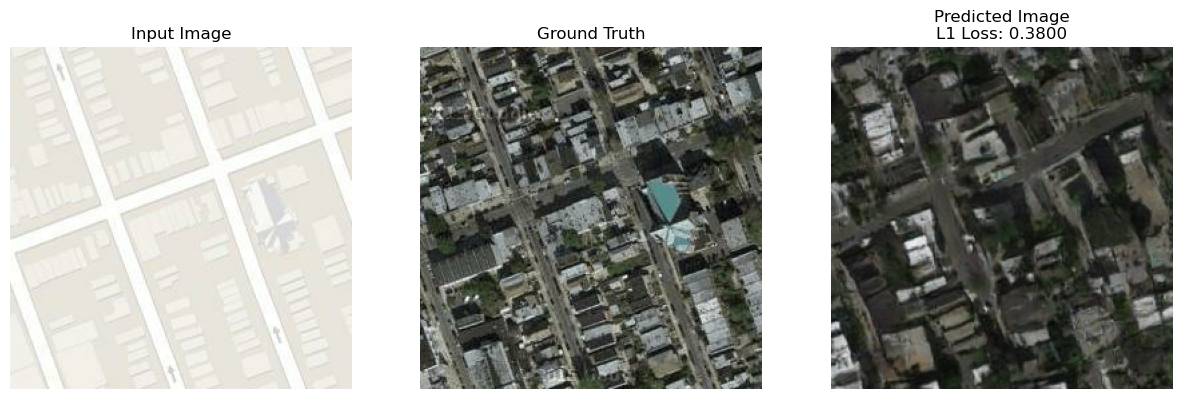

Epoch: 41, Step: 4384, Gen Loss: 4.8285, Disc Loss: 1.63742
Epoch: 42, Step: 4384, Gen Loss: 34.0207, Disc Loss: 0.0400
Epoch: 43, Step: 4384, Gen Loss: 15.1938, Disc Loss: 0.4334
Epoch: 44, Step: 4384, Gen Loss: 12.4059, Disc Loss: 0.6954
Epoch: 45, Step: 4384, Gen Loss: 21.3051, Disc Loss: 0.1377
Epoch: 46, Step: 4384, Gen Loss: 20.1130, Disc Loss: 0.7298
Epoch: 47, Step: 4384, Gen Loss: 5.3326, Disc Loss: 0.84185
Epoch: 48, Step: 4384, Gen Loss: 20.1004, Disc Loss: 0.5219
Epoch: 49, Step: 4384, Gen Loss: 31.2069, Disc Loss: 0.3501
Epoch: 50, Step: 4384, Gen Loss: 26.4236, Disc Loss: 0.4042


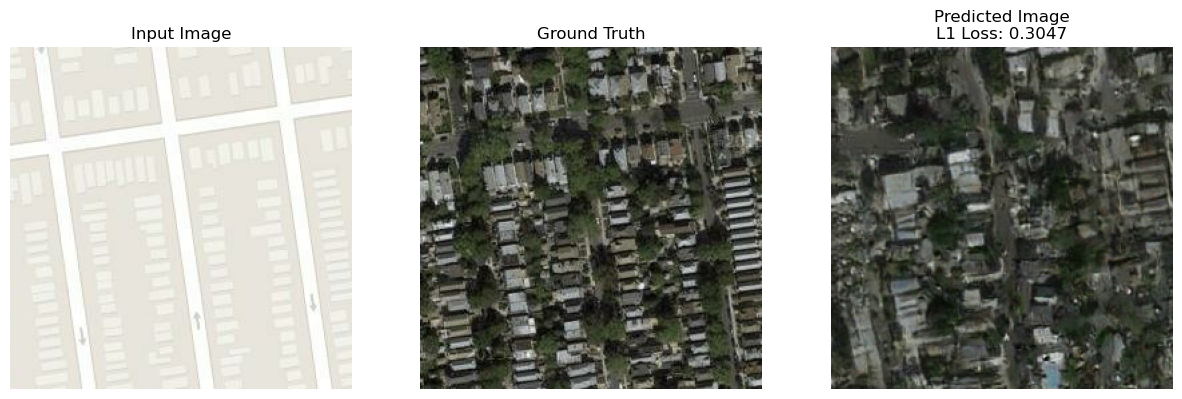

Epoch: 51, Step: 4384, Gen Loss: 29.8083, Disc Loss: 0.2588
Epoch: 52, Step: 4384, Gen Loss: 11.3245, Disc Loss: 0.8515
Epoch: 53, Step: 4384, Gen Loss: 23.3498, Disc Loss: 0.1104
Epoch: 54, Step: 4384, Gen Loss: 12.5274, Disc Loss: 0.7087
Epoch: 55, Step: 4384, Gen Loss: 28.1349, Disc Loss: 0.2367
Epoch: 56, Step: 4384, Gen Loss: 34.6419, Disc Loss: 1.6084
Epoch: 57, Step: 4384, Gen Loss: 25.6406, Disc Loss: 1.2611
Epoch: 58, Step: 4384, Gen Loss: 35.6729, Disc Loss: 0.0708
Epoch: 59, Step: 4384, Gen Loss: 37.4826, Disc Loss: 0.1240
Epoch: 60, Step: 4384, Gen Loss: 28.6872, Disc Loss: 0.2558


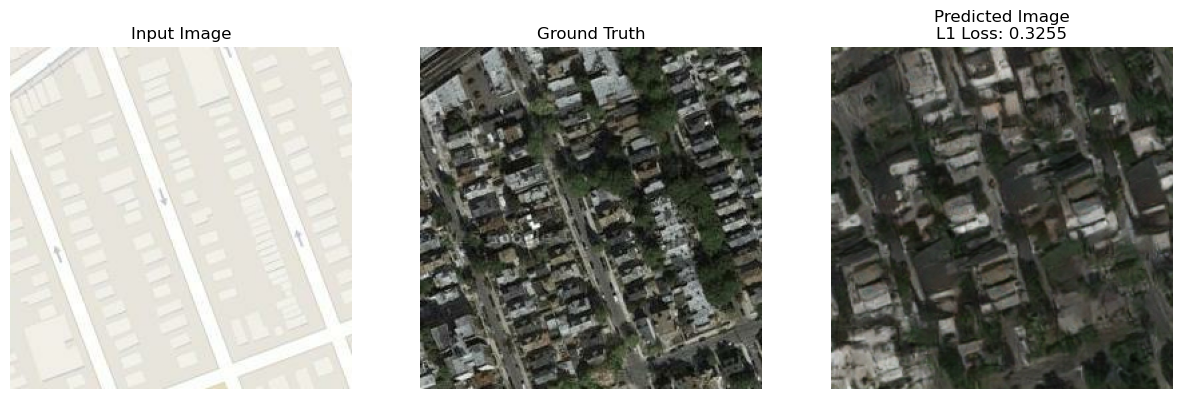

In [10]:
run = wandb.init(config=config, project="pix2pix")

fit(
    train_data=train,
    val_data=val,
    epochs=config["epochs"],
    generator=G,
    discriminator=D,
    generator_optimizer=g_optim,
    discriminator_optimizer=d_optim,
    l1_lambda=config["l1_lambda"],
)

In [11]:
wandb.finish()